In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


# Generate set of images and model

Found 459 images belonging to 3 classes.
Found 90 images belonging to 3 classes.
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 6147      
Total params: 23,593,859
Trainable params: 23,540,739
Non-trainable params: 53,120
_________________________________________________________________


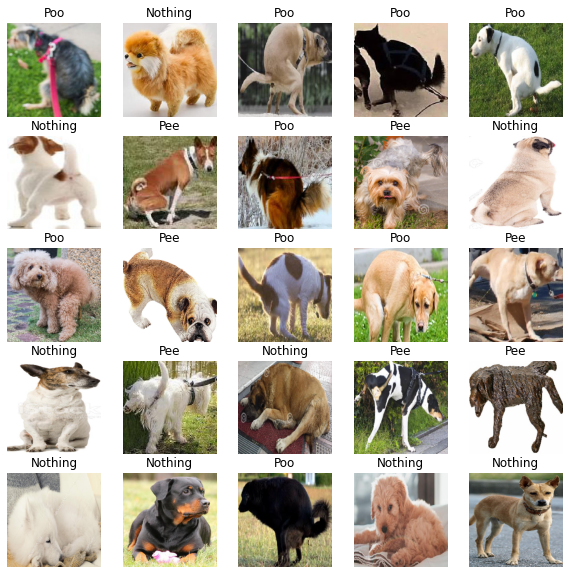

In [ ]:
import tensorflow as tf
import numpy as np
import pathlib
from tensorflow.keras import layers
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
data_dir = '/content/gdrive/My Drive/soma/images/3classes/train'
data_dir = pathlib.Path(data_dir)
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)


train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     class_mode='categorical')


validation_generator = image_generator.flow_from_directory(directory=str(data_dir), 
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           batch_size=BATCH_SIZE,
                                                           classes = list(CLASS_NAMES),
                                                           class_mode='categorical',
                                                           subset='validation') 

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

IMG_SHAPE = (IMG_WIDTH, IMG_HEIGHT, 3)

res_net = tf.keras.applications.ResNet50(
    weights = 'imagenet',
    include_top = False,
    input_shape = IMG_SHAPE)

res_net.trainable = True

global_average_layer = layers.GlobalAveragePooling2D()
output_layer = layers.Dense(3, activation='softmax')

tl_model = tf.keras.models.Sequential([
  res_net,
  global_average_layer,
  output_layer
])

tl_model.summary()

tl_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Train the model

In [ ]:

callbacks = [tf.keras.callbacks.TensorBoard(log_dir='./log/transer_learning_model', update_freq='batch')]
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
es = EarlyStopping(monitor='val_accuracy', mode='min', verbose=1, patience=50)

tl_model.fit_generator(train_data_gen, 
             steps_per_epoch = train_data_gen.samples // BATCH_SIZE,
             epochs=100,
            #  batch_size = BATCH_SIZE,
             validation_data=validation_generator,
             validation_steps = 2,
             callbacks=[es, mc]

             )

 6/14 [===========>..................] - ETA: 5s - loss: 5.4125e-04 - accuracy: 1.0000

KeyboardInterrupt: ignored

## save the model

In [ ]:
tl_model.save('/content/gdrive/My Drive/soma/good_model/3classes')

INFO:tensorflow:Assets written to: /content/gdrive/My Drive/soma/good_model/3classes/assets


# Predict

In [ ]:
predict_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

predict_dir = '/content/gdrive/My Drive/soma/images/3classes/test/'
predict_dir = pathlib.Path(predict_dir)

predict_data_gen = predict_generator.flow_from_directory(directory=str(predict_dir),
                                                     batch_size=BATCH_SIZE,
                                                     shuffle=True,
                                                     target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                     classes = list(CLASS_NAMES),
                                                     class_mode='categorical')



Found 133 images belonging to 3 classes.


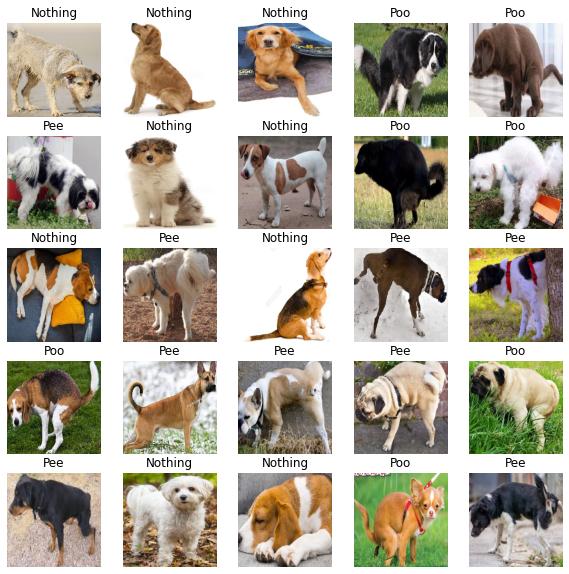

In [ ]:
p_image_batch, p_label_batch = next(predict_data_gen)
show_batch(p_image_batch, p_label_batch)

In [ ]:
#predict
predict_batch, p_label_batch = next(predict_data_gen)
output = tl_model.predict_generator(predict_batch)
print(np.argmax(output))

0


# Show the results

In [ ]:
#show confusion matrix
predicted=tl_model.predict_classes(predict_batch)
confusion = tf.math.confusion_matrix(labels=np.argmax(p_label_batch,axis=1), predictions=predicted, num_classes=3)
confusion

<tf.Tensor: shape=(3, 3), dtype=int32, numpy=
array([[13,  0,  0],
       [ 0,  4,  0],
       [ 1,  2, 12]], dtype=int32)>

In [ ]:
np.argmax(p_label_batch,axis=1)

array([0, 2, 2, 1, 0, 1, 2, 2, 2, 0, 2, 1, 2, 0, 2, 2, 0, 2, 0, 0, 2, 0,
       0, 2, 0, 0, 1, 0, 0, 2, 2, 2])

In [ ]:
predicted

array([0, 2, 1, 1, 0, 1, 2, 2, 2, 0, 2, 1, 2, 0, 1, 2, 0, 2, 0, 0, 2, 0,
       0, 2, 0, 0, 1, 0, 0, 0, 2, 2])

In [ ]:
#accuracy over 80%
for elem in output :
  if (np.max(elem) >= 0.8) :
    print(CLASS_NAMES[np.argmax(elem)])
  else :
    print("none")

NameError: ignored